# YOLO検討ノート

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [3]:
cv2.__version__

'3.1.0'

In [4]:
chainer.__version__

'1.22.0'

## ネットワーク構成

In [5]:
xp = np

N_BOXES = 1
N_CLASSES = 26  # 0..25
                # F.softmax_cross_entropy()で扱うラベルが
                # 0始まりの必要があるため、便宜的に0を追加
N_GRID = 7
INPUT_SIZE = 448
N_CNN_LAYER = 7

In [6]:
(N_GRID**2) * ((N_BOXES * 5) + N_CLASSES)

1519

In [7]:
class YoloClassifier(chainer.Chain):
    def __init__(self, gpu=-1):
        super(YoloClassifier, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6  = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7  = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            # addditonal layers for pretraining
            conv8  = L.Convolution2D(None, N_CLASSES, ksize=1, stride=1, pad=0),
        )
        self.train = False
        self.gpu = gpu
        if self.gpu >= 0: self.to_gpu()

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        # additional layers for pretraining
        h = self.conv8(h)
        h = F.average_pooling_2d(h, h.data.shape[-1], stride=1, pad=0)
        # reshape result tensor
        h = F.reshape(h, (batch_size, -1))
        return h

    def __call__(self, x, t):
        h = self.forward(x)
        self.loss = F.softmax_cross_entropy(h, t)
        self.accuracy = F.accuracy(h, t)
        if self.train:
            return self.loss
        else:
            return F.softmax(h)

In [219]:
class YoloDetector(chainer.Chain):
    def __init__(self, gpu=-1):
        super(YoloDetector, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6 = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv8 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv9 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            fc1 = L.Linear(50176, 256), # (1024,7,7)=50176
            fc2 = L.Linear(None, 4096),
            fc3 = L.Linear(None, ((N_BOXES*5)+N_CLASSES) * (N_GRID**2))
        )
        self.train = False
        self.class_prob_thresh = 0.3
        self.iou_thresh = 0.3
        self.gpu = gpu
        if self.gpu >= 0: self.to_gpu()

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        h = F.leaky_relu(self.conv8(h), slope=0.1)
        h = F.leaky_relu(self.conv9(h), slope=0.1)
        h = F.leaky_relu(self.fc1(h), slope=0.1)
        h = F.dropout(h, train=self.train, ratio=0.5)
        h = F.leaky_relu(self.fc2(h), slope=0.1)
        h = self.fc3(h)
        # reshape predicted tensor
        h = F.reshape(h, (batch_size, (5*N_BOXES)+N_CLASSES, N_GRID, N_GRID))
        return h

    def __call__(self, x, t):
        # 推論を実行
        px, py, pw, ph, pconf, pprob = self.forward(x)
        # 教師データを抽出
        if self.gpu >= 0: t.to_cpu()
        tx, ty, tw, th, tconf, _tprob = np.array_split(t.data, indices_or_sections=(1,2,3,4,5), axis=1)
#        tx, ty, tw, th, tconf, tprob = F.split_axis(t, indices_or_sections=(1,2,3,4,5), axis=1)
        if self.gpu >= 0: t.to_gpu()

        # オブジェクトが存在しないグリッドは、活性化後にグリッド中心となるよう学習
        tx[tconf != 1.0] = 0.5
        ty[tconf != 1.0] = 0.5
        # オブジェクトが存在しないグリッドは、学習させない
        if self.gpu >= 0: pprob.to_cpu()
        tprob = pprob.data.copy()
        if self.gpu >= 0: pprob.to_gpu()
        tprob[_tprob == 1.0] = 1.0
        # 学習係数を、オブジェクトが存在するグリッドか否かで調整
        box_learning_scale = np.tile(0.1, tconf.shape)
        box_learning_scale[tconf == 1.0] = 5.0
        conf_learning_scale = np.tile(0.5, tconf.shape)
        conf_learning_scale[tconf == 1.0] = 1.0
        prob_learning_scale = np.tile(0.0, tconf.shape)
        prob_learning_scale[tconf == 1.0] = 1.0

        # 損失誤差を算出
        tx = self.__variable(tx, np.float32)
        ty = self.__variable(ty, np.float32)
        tw = self.__variable(tw, np.float32)
        th = self.__variable(th, np.float32)
        tconf = self.__variable(tconf, np.float32)
        tprob = self.__variable(tprob, np.float32)
        if self.gpu >=0:
            tx.to_gpu(), ty.to_gpu(), tw.to_gpu(), th.to_gpu(), tconf.to_gpu(), tprob.to_gpu()
        box_learning_scale = self.__variable(box_learning_scale, np.float32)
        conf_learning_scale = self.__variable(conf_learning_scale, np.float32)
        prob_learning_scale = self.__variable(prob_learning_scale, np.float32)
        if self.gpu >=0:
            box_learning_scale.to_gpu(), conf_learning_scale.to_gpu(), prob_learning_scale.to_gpu()

#        print(type(tx), tx.shape, type(px), px.shape)
        x_loss = F.sum(box_learning_scale * ((tx - px) ** 2))
        y_loss = F.sum(box_learning_scale * ((ty - py) ** 2))
        w_loss = F.sum(box_learning_scale * ((tw - pw) ** 2))
        h_loss = F.sum(box_learning_scale * ((th - ph) ** 2))
        conf_loss = F.sum(conf_learning_scale * ((tconf - pconf) ** 2))
        prob_loss = F.sum(prob_learning_scale * F.reshape(F.sum(((tprob - pprob) ** 2), axis=1), prob_learning_scale.shape))
#        prob_loss = F.sum((tprob - pprob) ** 2)

        if self.train:
            print("loss x:%f y:%f w:%f h:%f conf:%f prob:%f" %
                  (x_loss.data, y_loss.data, w_loss.data, h_loss.data, conf_loss.data, prob_loss.data))
        self.loss = x_loss + y_loss + w_loss + h_loss + conf_loss + prob_loss

        if self.gpu >= 0:
            px.to_cpu(), py.to_cpu(), pw.to_cpu(), ph.to_cpu(), pconf.to_cpu(), pprob.to_cpu()
        self.detected_boxes = self.__detection(px, py, pw, ph, pconf, pprob)
        if self.gpu >= 0:
            px.to_gpu(), py.to_gpu(), pw.to_gpu(), ph.to_gpu(), pconf.to_gpu(), pprob.to_gpu()

        if self.train:
            return self.loss
        else:
            return self.detected_boxes

    def inference(self, x):
        px, py, pw, ph, pconf, pprob = self.forward(x)
        return self.__detection(px, py, pw, ph, pconf, pprob)

    def __detection(self, px, py, pw, ph, pconf, pprob):
        batch_size = px.data.shape[0]
        _px = F.reshape(px, (batch_size, N_GRID, N_GRID)).data
        _py = F.reshape(py, (batch_size, N_GRID, N_GRID)).data
        _pw = F.reshape(pw, (batch_size, N_GRID, N_GRID)).data
        _ph = F.reshape(ph, (batch_size, N_GRID, N_GRID)).data
        _pconf = F.reshape(pconf, (batch_size, N_GRID, N_GRID)).data
        _pprob = pprob.data

        boxes = []
        for i in range(0, batch_size):
            candidates = self.__select_candidates(
                _px[i], _py[i], _pw[i], _ph[i], _pconf[i], _pprob[i], self.class_prob_thresh)
            winners = self.__nms(candidates, self.iou_thresh)
            boxes.append(winners)
        return boxes

    def __select_candidates(self, px, py, pw, ph, pconf, pprob, class_prob_thresh):
        class_prob_map = pprob * pconf # クラス確率を算出 (N_CLASSES,N_GRID,N_GRID)
        candidate_map = class_prob_map.max(axis=0) > class_prob_thresh # 検出グリッド候補を決定 (N_GRID,N_GRID)
        candidate_label_map = class_prob_map.argmax(axis=0) # 検出グリッド候補のラベルを抽出 (N_GRID,N_GRID)
        candidates = []
        for i in range(0, candidate_map.sum()):
            candidates.append({
                'box': Box(px[candidate_map][i], py[candidate_map][i],
                        pw[candidate_map][i], ph[candidate_map][i]),
                #'conf': pconf[candidate_map][i],
                #'prob': pprob.transpose(1,2,0)[candidate_map][i],
                'objectness': class_prob_map.max(axis=0)[candidate_map][i],
                'label': candidate_label_map[candidate_map][i]
            })
        return candidatess

    def __nms(self, candidates, iou_thresh):
        sorted(candidates, key=lambda x: x['objectness'], reverse=True)
        winners = []

        if len(candidates) == 0:
            return winners

        winners.append(candidates[0]) # 第１候補は必ず採用
        for i in range(1, len(candidates)): # 第２候補以降は上位の候補とのIOU次第
            for j in range(0, i):
                if Box.iou(candidates[i]['box'], candidates[j]['box']) > iou_thresh:
                    break
            else:
                winners.append(candidates[i])
        return winners

    def __variable(self, v, t):
        return chainer.Variable(xp.asarray(v).astype(t))

## 学習データのロード

In [9]:
with open(os.path.join('..', '..', 'cache', 'train_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

600

In [10]:
train_dataset[0]

{u'bounding_boxes': [{u'class': u'12',
   u'height': u'845',
   u'width': u'358',
   u'x': u'922',
   u'y': u'56'}],
 u'classes': [u'12'],
 u'color_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/12/23/color.bmp',
 u'depth_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/12/23/depth.bmp.bmp',
 u'label_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/12/23/label.bmp',
 u'pattern_id': u'23'}

In [21]:
class Image():
    def __init__(self, path, width, height):
        image = cv2.imread(path)
        self.real_height, self.real_width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.image = cv2.resize(image, (width, height))

In [12]:
class Box():
    def __init__(self, x, y, width, height, clazz=0, objectness=1.0):
        self.left = x
        self.top = y
        self.right = x + width
        self.bottom = y + height
        self.clazz = clazz
        self.objectness = objectness

    @property
    def width(self):
        return self.right - self.left

    @property
    def height(self):
        return self.bottom - self.top

    @property
    def vertex(self):
        return ((self.left, self.top), (self.right-1, self.top),
                (self.left, self.bottom-1), (self.right-1, self.bottom-1))

    def area(self):
        return float(self.width * self.height)

    @classmethod
    def overlap(clazz, box1, box2):
        left = max(box1.left, box2.left)
        top = max(box1.top, box2.top)
        right = min(box1.right, box2.right)
        bottom = min(box1.bottom, box2.bottom)
        width = max(0, right - left)
        height = max(0, bottom - top)
        return Box(left, top, width, height)

    @classmethod
    def intersection(clazz, box1, box2):
        return Box.overlap(box1, box2).area()

    @classmethod
    def union(clazz, box1, box2):
        return box1.area() + box2.area() - Box.intersection(box1, box2)

    @classmethod
    def iou(clazz, box1, box2):
        return Box.intersection(box1, box2) / Box.union(box1, box2)

class GroundTruth():
    def __init__(self, width, height, bounding_boxes=[]):
        self.width = width
        self.height = height
        self.bounding_boxes = bounding_boxes

In [19]:
bounding_boxes = [Box(x=float(box['x']), y=float(box['y']),
                            width=float(box['width']), height=float(box['height']),
                            clazz=float(box['class'])) for box in train_dataset[0]['bounding_boxes']]
bounding_boxes[0]

<__main__.Box instance at 0x1170b1170>

In [22]:
image = Image(train_dataset[0]['color_image_path'], INPUT_SIZE, INPUT_SIZE)

In [23]:
image.image[150][380], image.image[380][150]

(array([12,  5, 39], dtype=uint8), array([31, 31, 22], dtype=uint8))

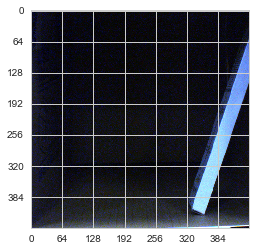

In [25]:
fig, axes = plt.subplots(1,1)
plt.xticks(range(0, 448, 64))
plt.yticks(range(0, 448, 64))
plt.imshow(image.image)
#plt.plot([3*64, 3*64 + 0.117*64], [6*64, 6*64 + 0.052*64], 'r', lw=2)

## 学習データのテンソルを作成

In [85]:
def parse_item_of_dataset(item):
    image = Image(item['color_image_path'], INPUT_SIZE, INPUT_SIZE)
    bounding_boxes = [Box(x=float(box['x']), y=float(box['y']),
                            width=float(box['width']), height=float(box['height']),
                            clazz=int(box['class'])) for box in item['bounding_boxes']]
    ground_truth = GroundTruth(width=image.real_width, height=image.real_height,
        bounding_boxes=bounding_boxes)
    return {'image': image, 'ground_truth': ground_truth}

In [86]:
dataset = filter(lambda item: item['bounding_boxes'] != [], train_dataset)
items = [parse_item_of_dataset(item) for item in dataset]
images = np.asarray([item['image'] for item in items])
ground_truths = np.asarray([item['ground_truth'] for item in items])

In [87]:
images[0], ground_truths[0]

(<__main__.Image instance at 0x188014fc8>,
 <__main__.GroundTruth instance at 0x17e3d5950>)

In [88]:
def parse_ground_truth(bounding_box, real_width, real_height):
    tw = bounding_box.width * INPUT_SIZE / real_width
    th = bounding_box.height * INPUT_SIZE / real_height
    tx = (bounding_box.left * INPUT_SIZE / real_width) + (tw / 2)
    ty = (bounding_box.top * INPUT_SIZE / real_height) + (th / 2)

    grid_size = INPUT_SIZE / N_GRID
    active_grid_cell = {
        'x': int(math.modf(tx / grid_size)[1]),
        'y': int(math.modf(ty / grid_size)[1])
    }
    norm_truth = { # [0..1] に正規化
        'x' : math.modf(tx / grid_size)[0],
        'y' : math.modf(ty / grid_size)[0],
        'w' : tw / INPUT_SIZE,
        'h' : th / INPUT_SIZE
    }
    one_hot_clazz = np.eye(N_CLASSES)[np.array(bounding_box.clazz)]

    # detection layerのテンソルに変換
    tensor = np.zeros(((5*N_BOXES)+N_CLASSES, N_GRID, N_GRID)).astype(np.float32)
    tensor[:5, active_grid_cell['y'], active_grid_cell['x']] \
        = [norm_truth['x'], norm_truth['y'], norm_truth['w'], norm_truth['h'], 1.0]
    tensor[5:, active_grid_cell['y'], active_grid_cell['x']] = one_hot_clazz
    return tensor

In [89]:
def make_ground_truth_tensor(ground_truth):
    each_tensors = [parse_ground_truth(box, ground_truth.width, ground_truth.height)
                        for box in ground_truth.bounding_boxes]
    return reduce(lambda x, y: x + y, each_tensors)

In [90]:
image_tensors  = np.asarray([image.image for image in images]).transpose(0,3,1,2)
ground_truth_tensors = np.asarray([make_ground_truth_tensor(truth) for truth in ground_truths])

image_tensors.shape, ground_truth_tensors.shape

((600, 3, 448, 448), (600, 31, 7, 7))

## ミニバッチ時の学習データの抽出

In [91]:
batch_size = 10

In [92]:
n_train = len(ground_truths)
n_train

600

In [93]:
perm = np.random.permutation(n_train)
perm[0:5]

array([294, 433, 265,   2, 430])

In [94]:
count = 0
ix = perm[count:count+batch_size]
x = chainer.Variable(xp.asarray(image_tensors[ix]).astype(np.float32))
t = chainer.Variable(xp.asarray(ground_truth_tensors[ix]).astype(np.float32))

In [95]:
x.shape, t.shape

((10, 3, 448, 448), (10, 31, 7, 7))

## 検出器のセットアップ

In [220]:
detector_model = YoloDetector()
detector_optimizer = chainer.optimizers.Adam()
detector_optimizer.setup(detector_model)

## 推論を実行

In [221]:
h = detector_model.forward(x)

In [261]:
h2 = F.sigmoid(h)

In [234]:
_px, _py, _pw, _ph, _pconf, _pprob = F.split_axis(h.data, indices_or_sections=(1,2,3,4,5), axis=1)
_px = F.sigmoid(_px).data
_py = F.sigmoid(_py).data
_pw = F.sigmoid(_pw).data
_ph = F.sigmoid(_ph).data
_pconf = F.sigmoid(_pconf).data
_pprob = F.sigmoid(_pprob).data

In [267]:
_px2, _py2, _pw2, _ph2, _pconf2, _pprob2 = np.array_split(h2.data, indices_or_sections=(1,2,3,4,5), axis=1)

In [277]:
_px2[0][0][0][0] = -1
_px2[0][0]

array([[-1.        ,  0.13344583,  0.91010243,  0.1460737 ,  0.40128991,
         0.51702583,  0.57517201],
       [ 0.04876372,  0.29020485,  0.99930859,  0.93551981,  0.05357945,
         0.86496329,  0.99785376],
       [ 0.82082754,  0.27134973,  0.2106505 ,  0.42414856,  0.97827983,
         0.52681172,  0.92448193],
       [ 0.74471402,  0.22758949,  0.07767206,  0.99378127,  0.43946666,
         0.63642144,  0.89852059],
       [ 0.11715493,  0.37505376,  0.03614116,  0.00101459,  0.74491358,
         0.23284879,  0.54585719],
       [ 0.17654884,  0.34766054,  0.34777841,  0.18494397,  0.03876951,
         0.955625  ,  0.42072499],
       [ 0.65734005,  0.7649737 ,  0.98942077,  0.39563155,  0.43352816,
         0.07697165,  0.74792385]], dtype=float32)

In [275]:
h3 = chainer.cuda.to_cpu(h2.data.copy())
h3.shape

(10, 31, 7, 7)

In [276]:
h3[0][0][0][0] = -2.0
h3[0][0]

array([[ -2.00000000e+00,   1.33445829e-01,   9.10102427e-01,
          1.46073699e-01,   4.01289910e-01,   5.17025828e-01,
          5.75172007e-01],
       [  4.87637222e-02,   2.90204853e-01,   9.99308586e-01,
          9.35519814e-01,   5.35794497e-02,   8.64963293e-01,
          9.97853756e-01],
       [  8.20827544e-01,   2.71349728e-01,   2.10650504e-01,
          4.24148560e-01,   9.78279829e-01,   5.26811719e-01,
          9.24481928e-01],
       [  7.44714022e-01,   2.27589488e-01,   7.76720643e-02,
          9.93781269e-01,   4.39466655e-01,   6.36421442e-01,
          8.98520589e-01],
       [  1.17154926e-01,   3.75053763e-01,   3.61411572e-02,
          1.01459026e-03,   7.44913578e-01,   2.32848793e-01,
          5.45857191e-01],
       [  1.76548839e-01,   3.47660542e-01,   3.47778410e-01,
          1.84943974e-01,   3.87695134e-02,   9.55624998e-01,
          4.20724988e-01],
       [  6.57340050e-01,   7.64973700e-01,   9.89420772e-01,
          3.95631552e-01,   4.33

In [264]:
h2.data[0][0]

array([[ 0.66239929,  0.13344583,  0.91010243,  0.1460737 ,  0.40128991,
         0.51702583,  0.57517201],
       [ 0.04876372,  0.29020485,  0.99930859,  0.93551981,  0.05357945,
         0.86496329,  0.99785376],
       [ 0.82082754,  0.27134973,  0.2106505 ,  0.42414856,  0.97827983,
         0.52681172,  0.92448193],
       [ 0.74471402,  0.22758949,  0.07767206,  0.99378127,  0.43946666,
         0.63642144,  0.89852059],
       [ 0.11715493,  0.37505376,  0.03614116,  0.00101459,  0.74491358,
         0.23284879,  0.54585719],
       [ 0.17654884,  0.34766054,  0.34777841,  0.18494397,  0.03876951,
         0.955625  ,  0.42072499],
       [ 0.65734005,  0.7649737 ,  0.98942077,  0.39563155,  0.43352816,
         0.07697165,  0.74792385]], dtype=float32)

In [246]:
(_pprob == _pprob2).sum(), _pprob.shape

(12740, (10, 26, 7, 7))

In [349]:
px, py, pw, ph, pconf, pprob = detector_model.forward(x)

px.data.shape, py.data.shape, pw.data.shape, ph.data.shape, pconf.data.shape, pprob.data.shape

ValueError: too many values to unpack

In [350]:
type(px)

numpy.ndarray

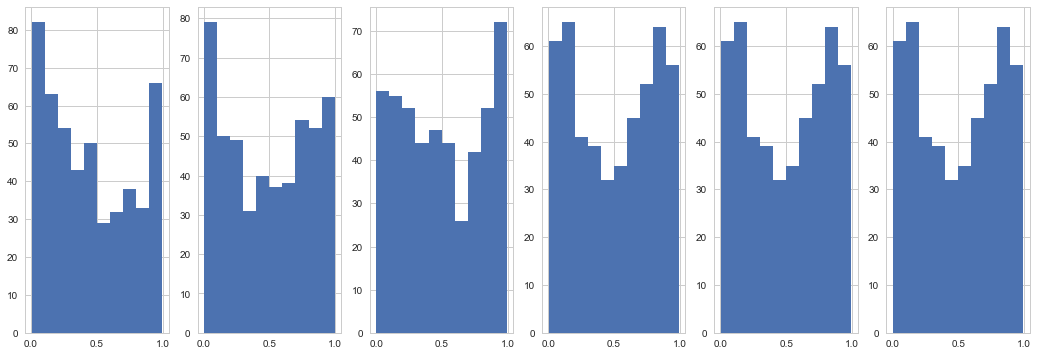

In [98]:
fig, axes = plt.subplots(1, 6, figsize=(18, 6))
axes[0].hist(px.data.flatten())
axes[1].hist(py.data.flatten())
axes[2].hist(pw.data.flatten())
axes[3].hist(ph.data.flatten())
axes[4].hist(ph.data.flatten())
axes[5].hist(ph.data.flatten())
pass

In [347]:
tx, ty, tw, th, tconf, tprob = np.array_split(ground_truth_tensors[0:batch_size], indices_or_sections=(1,2,3,4,5), axis=1)

tx.shape, ty.shape, tw.shape, tconf.shape, tprob.shape

((10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 26, 7, 7))

In [348]:
type(tx)

numpy.ndarray

In [373]:
np.max(F.sigmoid(tconf).data)

0.7310586

In [55]:
tconf[0]

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]], dtype=float32)

In [56]:
tx[tconf != 1.0] = 0.5

tx[0]

array([[[ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.02109375],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
          0.5       ,  0.5       ]]], dtype=float32)

In [356]:
np.sum(((tx - px)**2))

3221.479

In [58]:
box_learning_scale = np.tile(0.1, tx.shape)
box_learning_scale[tconf == 1.0] = 1.0

box_learning_scale[0]

array([[[ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  1. ],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1]]])

In [59]:
(box_learning_scale * ((tx - px)**2)).data[0]

array([[[ 0.02291278,  0.0235088 ,  0.02269273,  0.01045335,  0.02428683,
          0.02374924,  0.02467606],
        [ 0.02473557,  0.02201991,  0.00056687,  0.01055628,  0.0180616 ,
          0.00024662,  0.01990085],
        [ 0.00803859,  0.00477492,  0.022156  ,  0.00244686,  0.00827087,
          0.00091329,  0.02275088],
        [ 0.02386528,  0.0150799 ,  0.0217894 ,  0.01079938,  0.00371191,
          0.0139293 ,  0.08319464],
        [ 0.0162485 ,  0.00030811,  0.02186172,  0.00795038,  0.00029244,
          0.01583781,  0.01585721],
        [ 0.00679821,  0.01439763,  0.01277305,  0.01850922,  0.0152969 ,
          0.02293861,  0.01630628],
        [ 0.00520845,  0.00724031,  0.00699789,  0.00220357,  0.00553496,
          0.0232324 ,  0.01279845]]], dtype=float32)

In [60]:
F.sum(box_learning_scale * ((tx - px)**2)).data

array(8.656530380249023, dtype=float32)

In [62]:
tprob[0][12,:,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [63]:
_tprob = pprob.data.copy()
_tprob[tprob == 1.0] = 1.0
_tprob[0][12,:,:]

array([[  9.40730333e-01,   8.38745177e-01,   5.65141439e-04,
          8.25492680e-01,   8.39795887e-01,   8.77473831e-01,
          9.98300433e-01],
       [  8.00702572e-01,   8.88139904e-02,   8.99087548e-01,
          5.92847764e-01,   4.43778723e-01,   9.07799602e-03,
          4.82998550e-01],
       [  7.63696432e-01,   8.36022735e-01,   1.05861247e-01,
          6.16102219e-01,   8.46502781e-01,   8.67969990e-01,
          1.27085149e-02],
       [  9.10361171e-01,   7.02927470e-01,   1.61120296e-02,
          6.75421953e-03,   2.99497426e-01,   5.69968283e-01,
          1.00000000e+00],
       [  5.11006415e-01,   1.95477009e-01,   2.99916267e-02,
          9.44255710e-01,   5.05740345e-01,   2.00035274e-02,
          6.22533202e-01],
       [  2.85369754e-02,   6.79784238e-01,   5.73244691e-03,
          7.44330227e-01,   5.21380603e-02,   9.83356714e-01,
          4.32427466e-01],
       [  9.00005937e-01,   3.16313803e-01,   1.81277394e-01,
          8.43282640e-01,   2.37

In [64]:
((_tprob - pprob)**2).data[0][12,:,:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.33099449],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [65]:
F.sum((_tprob - pprob)**2).data

array(3.000241756439209, dtype=float32)

In [66]:
_tprob_err = F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)
_tprob_err.data[0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.33099449],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [67]:
prob_learning_scale = np.tile(0.0, tconf.shape)
prob_learning_scale[tconf == 1.0] = 1.0

In [68]:
F.sum(prob_learning_scale * F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)).data

array(3.000241756439209, dtype=float32)

## 推論結果を検出座標に変換

In [69]:
_px = F.reshape(px, (batch_size, N_GRID, N_GRID)).data
_py = F.reshape(py, (batch_size, N_GRID, N_GRID)).data
_pw = F.reshape(pw, (batch_size, N_GRID, N_GRID)).data
_ph = F.reshape(ph, (batch_size, N_GRID, N_GRID)).data
_pconf = F.reshape(pconf, (batch_size, N_GRID, N_GRID)).data
_pprob = pprob.data

_px.shape, _py.shape, _pw.shape, _ph.shape, _pconf.shape, _pprob.shape

((10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 26, 7, 7))

In [214]:
_pobj = (_pprob[0] * _pconf[0]).transpose(1,2,0)
_pobj[1,3]

array([ 0.43308464,  0.11953532,  0.29049623,  0.44944125,  0.25558978,
        0.3585023 ,  0.61695206,  0.02689682,  0.11112458,  0.61580402,
        0.56997931,  0.36351889,  0.38775748,  0.39617181,  0.33856669,
        0.36801514,  0.23804198,  0.40024301,  0.09726732,  0.30708119,
        0.60552824,  0.6390807 ,  0.49021432,  0.46792892,  0.08237838,
        0.62170118], dtype=float32)

In [286]:
_class_probs = _pprob[0] * _pconf[0]
_max_class_probs_map = _class_probs.max(axis=0)
_max_class_probs_map

array([[ 0.5436852 ,  0.87299973,  0.54632992,  0.85493296,  0.79055774,
         0.04883667,  0.82923347],
       [ 0.97029114,  0.99650782,  0.85720515,  0.29600522,  0.2879642 ,
         0.67986673,  0.996961  ],
       [ 0.26799804,  0.19504192,  0.28671658,  0.86294001,  0.85752749,
         0.93175137,  0.04307476],
       [ 0.01909542,  0.21990483,  0.97203565,  0.97640979,  0.07439857,
         0.90765405,  0.97738111],
       [ 0.04907788,  0.57511681,  0.99103165,  0.30767789,  0.16018122,
         0.14995499,  0.72690445],
       [ 0.89716494,  0.43719345,  0.94334656,  0.80119491,  0.32274631,
         0.61169893,  0.61864322],
       [ 0.45193967,  0.77233005,  0.51528579,  0.10030524,  0.13502592,
         0.06036985,  0.98146945]], dtype=float32)

In [71]:
_candidate_map = _class_probs.max(axis=0) > 0.8
_candidate_label_map = _class_probs.argmax(axis=0)

In [72]:
_candidate_map

array([[ True,  True, False, False, False, False,  True],
       [False,  True,  True, False,  True, False, False],
       [ True, False, False, False, False,  True,  True],
       [False, False,  True, False, False, False, False],
       [False, False, False, False, False, False, False],
       [ True, False, False,  True,  True, False, False],
       [False, False, False, False, False, False, False]], dtype=bool)

In [73]:
[{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map == True)]

[{u'x': 0, u'y': 0},
 {u'x': 0, u'y': 1},
 {u'x': 0, u'y': 6},
 {u'x': 1, u'y': 1},
 {u'x': 1, u'y': 2},
 {u'x': 1, u'y': 4},
 {u'x': 2, u'y': 0},
 {u'x': 2, u'y': 5},
 {u'x': 2, u'y': 6},
 {u'x': 3, u'y': 2},
 {u'x': 5, u'y': 0},
 {u'x': 5, u'y': 3},
 {u'x': 5, u'y': 4}]

In [74]:
_candidate_label_map

array([[24,  6, 15,  6,  2, 21, 12],
       [ 8, 21,  1, 21,  7, 17,  8],
       [ 0, 14, 24, 13, 14, 19, 23],
       [10, 10,  0,  4,  5,  9, 10],
       [22, 19, 17, 14, 22, 20, 25],
       [ 8,  5, 25,  9,  1, 12,  2],
       [ 1, 13,  7,  3,  6, 12, 18]])

In [75]:
_class_probs.max(axis=0)[_candidate_map]

array([ 0.90152502,  0.85380548,  0.89205629,  0.89233375,  0.95446438,
        0.98490131,  0.94074458,  0.92160505,  0.80516946,  0.98693234,
        0.95798028,  0.98222834,  0.98073554], dtype=float32)

In [76]:
_candidate_label_map[_candidate_map]

array([24,  6, 12, 21,  1,  7,  0, 19, 23,  0,  8,  9,  1])

In [77]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].max() * _pconf[0][_candidate_map][0]

0.90152502

In [78]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].argmax()

24

In [79]:
def __select_candidates(self, px, py, pw, ph, pconf, pprob, class_prob_thresh):
    class_prob_map = pprob * pconf # クラス確率を算出 (N_CLASSES,N_GRID,N_GRID)
    candidate_map = class_prob_map.max(axis=0) > class_prob_thresh # グリッド候補 (N_GRID,N_GRID)
    candidate_class_map = class_prob_map.argmax(axis=0) # グリッド候補のクラス (N_GRID,N_GRID)
    active_grid_cells = [{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map)] # グリッド候補の位置
    candidates = []
    for i in range(0, candidate_map.sum()):
        candidates.append({
            'box': Box(px[candidate_map][i], py[candidate_map][i],
                       pw[candidate_map][i], ph[candidate_map][i]),
            #'conf': pconf[candidate_map][i],
            #'prob': pprob.transpose(1,2,0)[candidate_map][i],
            'objectness': class_prob_map.max(axis=0)[candidate_map][i],
            'class': candidate_class_map[candidate_map][i],
            'active_grid_cell': active_grid_cells[i]
        })
    return candidates

In [80]:
def __nms(self, candidates, iou_thresh):
    sorted(candidates, key=lambda x: x['objectness'], reverse=True)
    winners = []

    if len(candidates) == 0:
        return winners

    winners.append(candidates[0]) # 第１候補は必ず採用
    for i in range(1, len(candidates)): # 第２候補以降は上位の候補とのIOU次第
        for j in range(0, i):
            if Box.iou(candidates[i]['box'], candidates[j]['box']) > iou_thresh:
                break
        else:
            winners.append(candidates[i])
    return winners

In [99]:
i = 0
candidates = __select_candidates(None, _px[i], _py[i], _pw[i], _ph[i], _pconf[i], _pprob[i], 0.9)
winners = __nms(None, candidates, 0.3)

len(candidates), len(winners)

(9, 8)

In [100]:
winners

[{u'active_grid_cell': {u'x': 0, u'y': 0},
  u'box': <__main__.Box instance at 0x130aff3f8>,
  u'class': 24,
  u'objectness': 0.90152502},
 {u'active_grid_cell': {u'x': 0, u'y': 1},
  u'box': <__main__.Box instance at 0x1880bdea8>,
  u'class': 1,
  u'objectness': 0.95446438},
 {u'active_grid_cell': {u'x': 0, u'y': 6},
  u'box': <__main__.Box instance at 0x1880c6050>,
  u'class': 7,
  u'objectness': 0.98490131},
 {u'active_grid_cell': {u'x': 1, u'y': 1},
  u'box': <__main__.Box instance at 0x1880c6170>,
  u'class': 0,
  u'objectness': 0.94074458},
 {u'active_grid_cell': {u'x': 1, u'y': 2},
  u'box': <__main__.Box instance at 0x19e665f80>,
  u'class': 19,
  u'objectness': 0.92160505},
 {u'active_grid_cell': {u'x': 1, u'y': 4},
  u'box': <__main__.Box instance at 0x19e665e18>,
  u'class': 0,
  u'objectness': 0.98693234},
 {u'active_grid_cell': {u'x': 2, u'y': 0},
  u'box': <__main__.Box instance at 0x19e665e60>,
  u'class': 8,
  u'objectness': 0.95798028},
 {u'active_grid_cell': {u'x': 2,

In [103]:
def final_detection(result, real_width, real_height):
    grid_size = INPUT_SIZE / N_GRID
    pred_x = (result['box']).left
    pred_y = (result['box']).top
    pred_w = (result['box']).width
    pred_h = (result['box']).height
    active_grid_cell = result['active_grid_cell']
    
    return {
        'x': (active_grid_cell['x'] + pred_x) * grid_size * real_width / INPUT_SIZE,
        'y': (active_grid_cell['y'] + pred_y) * grid_size * real_height / INPUT_SIZE,
        'width': pred_w * real_width,
        'height': pred_h * real_height,
        'class': result['class'],
        'objectness': result['objectness']
    }

In [104]:
final_detection(winners[0], 1280, 960)

{u'class': 24,
 u'height': 887.18484878540039,
 u'objectness': 0.90152502,
 u'width': 1063.7509155273438,
 u'x': 3.8998086111886159,
 u'y': 98.46013477870396}

In [187]:
def check_correct_detection(pred, truths):
    # TODO: pred,truthsをBoxに変換
    best_iou, best_truth = Box.best_iou(pred, truth)
    if best_iou <= 0.5:
        return False
    if pred.class != best_truth.class
        return False
    return True

In [155]:
positives = {str(i): {'true': 0, 'false': 0}  for i in range(0, N_CLASSES)}

In [156]:
positives.items()

[('24', {u'false': 0, u'true': 0}),
 ('25', {u'false': 0, u'true': 0}),
 ('20', {u'false': 0, u'true': 0}),
 ('21', {u'false': 0, u'true': 0}),
 ('22', {u'false': 0, u'true': 0}),
 ('23', {u'false': 0, u'true': 0}),
 ('1', {u'false': 0, u'true': 0}),
 ('0', {u'false': 0, u'true': 0}),
 ('3', {u'false': 0, u'true': 0}),
 ('2', {u'false': 0, u'true': 0}),
 ('5', {u'false': 0, u'true': 0}),
 ('4', {u'false': 0, u'true': 0}),
 ('7', {u'false': 0, u'true': 0}),
 ('6', {u'false': 0, u'true': 0}),
 ('9', {u'false': 0, u'true': 0}),
 ('8', {u'false': 0, u'true': 0}),
 ('11', {u'false': 0, u'true': 0}),
 ('10', {u'false': 0, u'true': 0}),
 ('13', {u'false': 0, u'true': 0}),
 ('12', {u'false': 0, u'true': 0}),
 ('15', {u'false': 0, u'true': 0}),
 ('14', {u'false': 0, u'true': 0}),
 ('17', {u'false': 0, u'true': 0}),
 ('16', {u'false': 0, u'true': 0}),
 ('19', {u'false': 0, u'true': 0}),
 ('18', {u'false': 0, u'true': 0})]

In [170]:
def precision(tp, fp):
    if tp == 0 and fp == 0:
        return 0
    else:
        return float(tp) / (tp + fp)
            

average_precisions = {str(p[0]): precision(p[1]['true'], p[1]['false']) for p in positives.items()}

len(average_precisions.values())

26

In [173]:
import six
for count in six.moves.range(0, 149, 10):
    print (count)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


### モニタリングする指標
- 検出数
- mean average precision

In [176]:
arr = np.asarray([Box(1,2,3,4), Box(5,6,7,8)])
type(arr)

numpy.ndarray

In [185]:
np.savez('foo.npz', data=arr)
arr2 = np.load('foo.npz')

for box in arr2['data']:
    print (box.vertex[0], box.width, box.height)

(1, 2) 3 4
(5, 6) 7 8


### Boxクラス
- x
- y
- width
- height

### Ground Truthクラス
- width
- height
- bounding_boxes
  - box
  - class
  - objectness


In [188]:
[x + 1
    for x in np.arange(0,5)]

[1, 2, 3, 4, 5]

In [178]:
np.random.rand((1,3,5,5)).shape

TypeError: an integer is required

In [306]:
a = np.arange(1, 6)
a[1:]

array([2, 3, 4, 5])

In [217]:
for i, item in enumerate(a[1:], 1):
    print(i, item)

1 2
2 3
3 4
4 5


In [299]:
b = np.arange(11, 16)
b

array([11, 12, 13, 14, 15])

In [296]:
for i, (a, b) in enumerate(zip(a, b), 1):
    print (i, a, b)

1 1 11
2 2 12
3 3 13
4 4 14
5 5 15


In [304]:
np.sort(b)[::-1]

array([15, 14, 13, 12, 11])

In [309]:
import itertools
for _a, _b in itertools.product(a, b):
    print(_a, _b)

1 11
1 12
1 13
1 14
1 15
2 11
2 12
2 13
2 14
2 15
3 11
3 12
3 13
3 14
3 15
4 11
4 12
4 13
4 14
4 15
5 11
5 12
5 13
5 14
5 15


In [313]:
a = [1,2,3,4,5]
type(a)

list

In [320]:
a = [0.2, 0.1, 0.5, 0.9, 0.8]
np.asarray(a).mean()

0.5

In [321]:
750 * (3.5+3.5)

5250.0

In [324]:
loss = chainer.Variable(xp.asarray([0.]).astype(np.float32))
loss.data

array([ 0.], dtype=float32)

In [327]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h.data, indices_or_sections=(1,2,3,4,5), axis=1)

In [329]:
h2 = h.data.copy()
h2.shape

(10, 31, 7, 7)

In [330]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h2, indices_or_sections=(1,2,3,4,5), axis=1)

In [336]:
px[0][0][_candidate_map]

array([ 0.67400473, -1.87082911,  0.30298477, -0.89438933,  7.27609015,
       -2.87152147,  1.52196419,  0.10734994,  2.50486135, -2.47440529,
       -1.53990662, -1.48320389, -3.21057987], dtype=float32)

In [345]:
px0 = px[0]
px0.shape

(1, 7, 7)

In [346]:
px0 = px0.reshape(px0.shape[1:])
px0.shape

(7, 7)

In [378]:
a = F.sum(xp.asarray([1.0]))
a.data

array(1.0)

In [381]:
np.reshape?

In [394]:
h2.shape

(10, 31, 7, 7)

In [397]:
h3 = h2[0]
h3.shape

(31, 7, 7)

In [399]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h3, indices_or_sections=(1,2,3,4,5), axis=0)
px.shape

(1, 7, 7)

In [400]:
np.tile(True, (N_GRID, N_GRID))

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]], dtype=bool)

In [405]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return '<Point x:%4.1f y:%4.1f>' % (self.x, self.y)

In [406]:
grid_cells = [Point(x=float(point[1]), y=float(point[0]))
                for point in np.argwhere(np.tile(True, (N_GRID, N_GRID)))]

In [407]:
grid_cells

[<Point x: 0.0 y: 0.0>,
 <Point x: 1.0 y: 0.0>,
 <Point x: 2.0 y: 0.0>,
 <Point x: 3.0 y: 0.0>,
 <Point x: 4.0 y: 0.0>,
 <Point x: 5.0 y: 0.0>,
 <Point x: 6.0 y: 0.0>,
 <Point x: 0.0 y: 1.0>,
 <Point x: 1.0 y: 1.0>,
 <Point x: 2.0 y: 1.0>,
 <Point x: 3.0 y: 1.0>,
 <Point x: 4.0 y: 1.0>,
 <Point x: 5.0 y: 1.0>,
 <Point x: 6.0 y: 1.0>,
 <Point x: 0.0 y: 2.0>,
 <Point x: 1.0 y: 2.0>,
 <Point x: 2.0 y: 2.0>,
 <Point x: 3.0 y: 2.0>,
 <Point x: 4.0 y: 2.0>,
 <Point x: 5.0 y: 2.0>,
 <Point x: 6.0 y: 2.0>,
 <Point x: 0.0 y: 3.0>,
 <Point x: 1.0 y: 3.0>,
 <Point x: 2.0 y: 3.0>,
 <Point x: 3.0 y: 3.0>,
 <Point x: 4.0 y: 3.0>,
 <Point x: 5.0 y: 3.0>,
 <Point x: 6.0 y: 3.0>,
 <Point x: 0.0 y: 4.0>,
 <Point x: 1.0 y: 4.0>,
 <Point x: 2.0 y: 4.0>,
 <Point x: 3.0 y: 4.0>,
 <Point x: 4.0 y: 4.0>,
 <Point x: 5.0 y: 4.0>,
 <Point x: 6.0 y: 4.0>,
 <Point x: 0.0 y: 5.0>,
 <Point x: 1.0 y: 5.0>,
 <Point x: 2.0 y: 5.0>,
 <Point x: 3.0 y: 5.0>,
 <Point x: 4.0 y: 5.0>,
 <Point x: 5.0 y: 5.0>,
 <Point x: 6.0 y